In [1]:
#Step 0. Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [2]:
download('wordnet')
download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
stop_words = stopwords.words('english')

In [4]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/machine-learning-content/master/assets/spam.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df_raw.sample(10, random_state=2025)
#ham = contenido valido
#spam = propaganda

,Category,Message
2349,ham,That seems unnecessarily affectionate
5397,ham,That's necessarily respectful
4028,ham,"Yes, princess. Are you going to make me moan?"
3165,ham,TODAY is Sorry day.! If ever i was angry with ...
2738,ham,Hi Chachi tried calling u now unable to reach ...
2504,ham,Fwiw the reason I'm only around when it's time...
378,ham,Well there's not a lot of things happening in ...
3799,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to..."
5138,ham,Yup... I havent been there before... You want ...
4086,spam,Orange brings you ringtones from all time Char...


In [6]:
#Step 2. Preprocessing
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking['message'] = df_baking['message'].str.lower()
df_baking['message'] = df_baking['message'].str.strip()
df_baking['message'] = df_baking['message'].apply(lambda x: "haven't" if x == "havent" else x)
df_baking['message'] = df_baking['message'].apply(lambda x: "this" if x == "dis" else x)
df_baking['message'] = df_baking['message'].str.replace("&lt;#&gt;","")
df_baking['category'] = df_baking['category'].astype("category")
df_baking = df_baking.drop_duplicates()

def preprocess_text(text:str) -> list:
  text = re.sub(' dat ',' that ',text)
  text = re.sub(' da ', ' the ',text )
  text = re.sub(' ur ', ' your ',text )
  text = re.sub(' dun ', ' do you not ',text )
  text = re.sub(' c ', ' see ',text )
  text = re.sub(' b ', ' be ',text )
  return text

df_baking['message'] = df_baking['message'].apply(preprocess_text)

df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5156 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   category  5156 non-null   category
 1   message   5156 non-null   object  
dtypes: category(1), object(1)
memory usage: 85.7+ KB


In [7]:
df.sample(10, random_state=2025)

,category,message
2684,ham,i'm okay. chasing the dream. what's good. what...
2654,ham,sorry da:)i was thought of calling you lot of ...
4385,ham,thanks honey but still haven't heard anything ...
3124,ham,he telling not to tell any one. if so treat fo...
75,ham,i am waiting machan. call me once you free.
2141,ham,after the drug she will be able to eat.
3346,ham,reverse is cheating. that is not mathematics.
798,ham,petey boy whereare you me and all your friends...
2013,ham,beautiful truth against gravity.. read careful...
5320,ham,but we havent got the topic yet rite?


In [8]:
#Step 3. EDA
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=2025)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train.shape, df_test.shape

((4124, 2), (1032, 2))

In [9]:
df_train.describe().T

,count,unique,top,freq
category,4124,2,ham,3611
message,4124,4124,get ready for inches of pleasure...,1


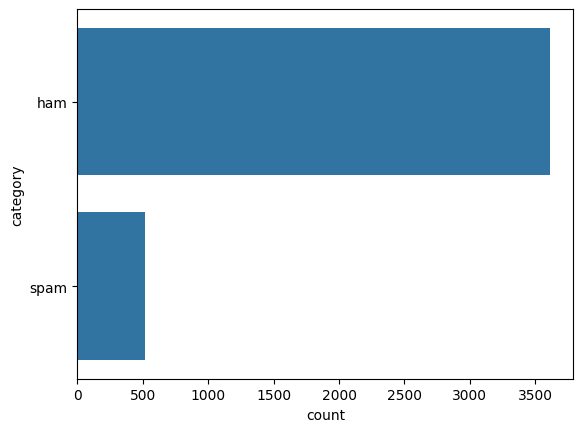

In [10]:
sns.countplot(df_train, y='category')
plt.show()

In [11]:
df_train['message'].str.split(expand=True).stack().value_counts()[:20]

,count
i,1720
to,1611
you,1490
the,1043
a,1042
your,730
and,722
u,706
in,641
is,628


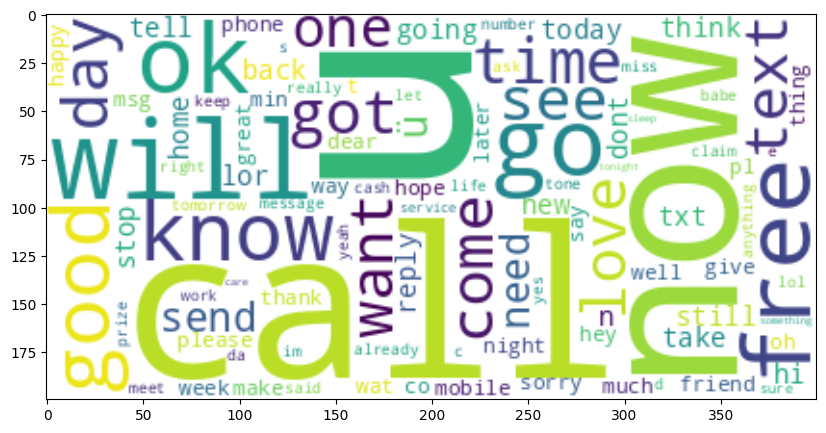

In [12]:
wc = WordCloud(
    max_words = 100,
    background_color = 'White',
    collocations=False
).generate(' '.join(df_train['message']))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.show()

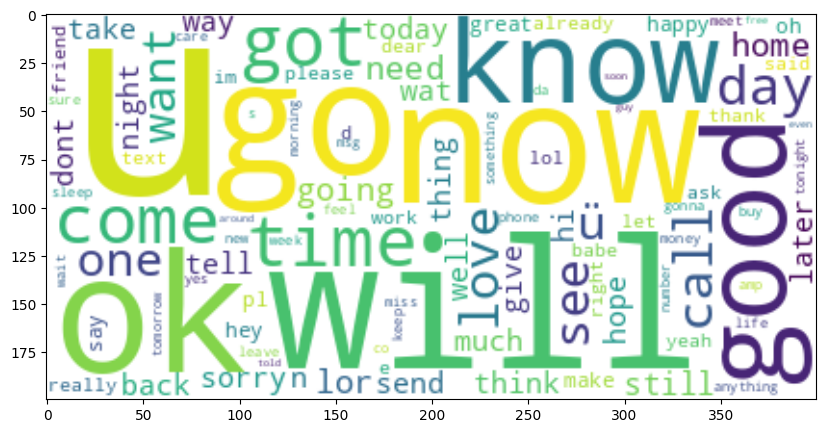

In [13]:
wc = WordCloud(
    max_words = 100,
    background_color = 'White',
    collocations=False
).generate(' '.join(df_train[df_train['category'] == 'ham']['message']))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.show()

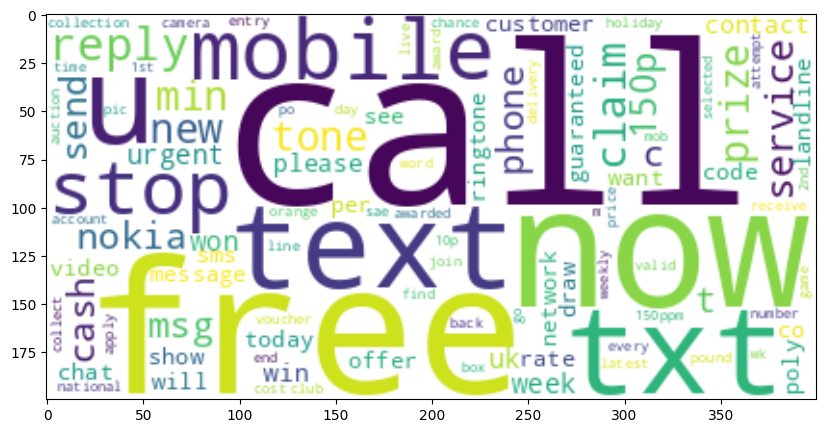

In [14]:
wc = WordCloud(
    max_words = 100,
    background_color = 'White',
    collocations=False
).generate(' '.join(df_train[df_train['category'] == 'spam']['message']))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.show()

In [15]:
#Step 4. Machine Learning

tokens_train_X = df_train['message']
y_train = df_train['category']
tokens_test_X = df_test['message']
y_test = df_test['category']

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [23]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words= stop_words)
X_train = vectorizer.fit_transform(tokens_train_X)
X_test = vectorizer.transform(tokens_test_X)

In [24]:
model = SVC(kernel='linear', random_state=2025, class_weight='balanced')
model.fit(X_train, y_train_enc)

SVC(class_weight='balanced', kernel='linear', random_state=2025)

In [25]:
y_hat = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat):.2f}')

Accuracy: 0.98


In [26]:
print(classification_report(y_test_enc, y_hat, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       904
        spam       0.94      0.93      0.94       128

    accuracy                           0.98      1032
   macro avg       0.97      0.96      0.96      1032
weighted avg       0.98      0.98      0.98      1032



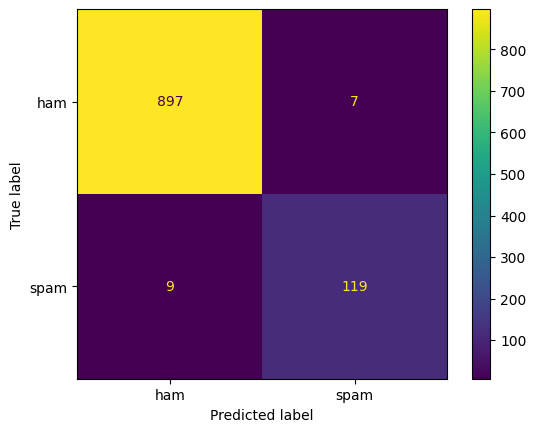

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat, display_labels=label_encoder.classes_)
plt.show()

In [37]:
#Step 4.1 Deep Learning

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(tokens_train_X)
X_test = vectorizer.transform(tokens_test_X)

X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

X_train_array.shape, X_test_array.shape

((4124, 5000), (1032, 5000))

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_array.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,724,865 (10.39 MB)

 Trainable params: 2,724,865 (10.39 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
    )

In [56]:
history = model.fit(
    X_train_array, y_train_enc,
    epochs=25, batch_size=128,
    validation_split=0.15
    )

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9995 - loss: 0.0015 - precision: 1.0000 - recall: 0.9961 - val_accuracy: 0.9709 - val_loss: 0.2146 - val_precision: 0.9848 - val_recall: 0.7927
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9999 - loss: 5.8132e-04 - precision: 1.0000 - recall: 0.9994 - val_accuracy: 0.9758 - val_loss: 0.1901 - val_precision: 0.9855 - val_recall: 0.8293
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9995 - loss: 0.0015 - precision: 1.0000 - recall: 0.9959 - val_accuracy: 0.9742 - val_loss: 0.1813 - val_precision: 0.9853 - val_recall: 0.8171
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9990 - loss: 0.0025 - precision: 1.0000 - recall: 0.9921 - val_accuracy: 0.9758 - val_loss: 0.1893 - val_precision: 0.9718 - val_recall: 0.8415
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9997 - loss: 9.8626e-04 - precision: 1.0000 - recall: 0.9977 - val_accuracy: 0.9758 - val_loss:

In [57]:
model.evaluate(X_test_array, y_test_enc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9732 - loss: 0.2579 - precision: 0.9775 - recall: 0.8168


[0.23858481645584106, 0.9748061895370483, 0.9636363387107849, 0.828125]

In [58]:
from transformers import pipeline

In [59]:
sentiment_pipeline = pipeline('sentiment-analysis',model='tabularisai/multilingual-sentiment-analysis')

Device set to use cpu


In [60]:
text = "Je n'aime pas les avions"
result = sentiment_pipeline(text)
print(result)

[{'label': 'Negative', 'score': 0.5748029947280884}]
